In [2]:
import pandas as pd
import requests

import geopandas as gpd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from scipy.stats import stats
from scipy.stats import pearsonr
from scipy import stats

df = pd.read_csv(r"gva_mass_shootings-2025-10-21.csv")
df.rename(columns={"state":"State"},inplace=True)

df.columns

Index(['incident_id', 'incident_date', 'incident_time', 'updated_date',
       'State', 'city_or_county', 'address', 'business_location_name',
       'latitude', 'longitude', 'killed', 'injured', 'victims_killed',
       'victims_injured', 'suspects_killed', 'suspects_injured',
       'suspects_arrested', 'incident_characteristics', 'sources',
       'date_fixed', 'year'],
      dtype='object')

In [3]:
years=list(range(2014,2025))
def get_edu(year):
    url_edu = f"https://api.census.gov/data/{year}/acs/acs1"
    params = {
        "get": "NAME,B15003_001E,B15003_002E,B15003_003E,B15003_004E,B15003_005E,"
        "B15003_006E,B15003_017E,B15003_022E,B15003_023E,B15003_025E",
        "for": "state:*"}
    response_1 = requests.get(url_edu, params=params)
    if response_1.status_code != 200:
        print(f"⚠️ {year}: HTTP {response_1.status_code} – skipping year")
        return pd.DataFrame()
    if not response_1.text.strip().startswith('[['):
        print(f"⚠️ {year}: invalid or empty response – skipping year")
        return pd.DataFrame()

    try:
        data = response_1.json()
    except Exception:
        print(f"⚠️ {year}: cannot decode JSON – skipping year")
        return pd.DataFrame()

    data = response_1.json()
    df_edu = pd.DataFrame(data[1:], columns=data[0])
    num_col=[column for column in df_edu.columns if column.startswith("B15003_")]
    df_edu[num_col] = df_edu[num_col].apply(pd.to_numeric, errors="coerce")

    df_edu = df_edu.rename(columns={
        "NAME": "State",
        "B15003_001E": "Population_25plus",
        "B15003_002E": "No_Schooling_Completed",
        "B15003_003E": "Nursery_to_4th_Grade",
        "B15003_004E": "5th_to_6th_Grade",
        "B15003_005E": "7th_to_8th_Grade",
        "B15003_006E": "9th_Grade",
        "B15003_017E": "High_School_Graduate",
        "B15003_022E": "Bachelor_Degree",
        "B15003_023E": "Master_Degree",
        "B15003_025E": "Doctorate_Degree","state": "State_Code"})

    col_min_studies=["No_Schooling_Completed",
        "Nursery_to_4th_Grade",
        "5th_to_6th_Grade",
        "7th_to_8th_Grade",
        "9th_Grade"]

    df_edu["Without Min Studies"] = df_edu[col_min_studies].sum(axis=1)

    df_edu.drop(columns=["No_Schooling_Completed",
     "Nursery_to_4th_Grade",
     "5th_to_6th_Grade",
     "7th_to_8th_Grade",
     "9th_Grade","State_Code"], inplace=True)
   
    df_edu["year"]=year
   
    df_edu = df_edu[[
        "year", "State", "Population_25plus",
        "Without Min Studies", "High_School_Graduate",
        "Bachelor_Degree", "Master_Degree", "Doctorate_Degree"
    ]]
    return df_edu
frame=[]
for year in years:
    print(f"Fetching {year}...")
    df_year = get_edu(year)
    if not df_year.empty:
        frame.append(df_year)
df_edu = pd.concat(frame, ignore_index=True)
df_edu



Fetching 2014...
Fetching 2015...
Fetching 2016...
Fetching 2017...
Fetching 2018...
Fetching 2019...
Fetching 2020...
⚠️ 2020: HTTP 404 – skipping year
Fetching 2021...
Fetching 2022...
Fetching 2023...
Fetching 2024...


,year,State,Population_25plus,Without Min Studies,High_School_Graduate,Bachelor_Degree,Master_Degree,Doctorate_Degree
0,2014,Alabama,3256766,48873,847523,478058,201391,33082
1,2014,Alaska,465149,4144,108523,85634,33103,4304
2,2014,Arizona,4436226,77042,899108,765784,328400,53578
3,2014,Arkansas,1968414,25814,568437,272411,104636,19380
4,2014,California,25654292,814956,4768478,5120162,2035257,394265
...,...,...,...,...,...,...,...,...
515,2024,Washington,5631460,105363,975478,1372926,683345,113323
516,2024,West Virginia,1268689,14987,420214,187714,88027,13183
517,2024,Wisconsin,4172638,48054,1057997,943201,362471,61628
518,2024,Wyoming,409344,4684,90634,82918,35122,8475


In [4]:
def total_pop(year):
    url = f"https://api.census.gov/data/{year}/acs/acs1"
    params = {"get": "NAME,B01003_001E", "for": "state:*"}
    r = requests.get(url, params=params)
    if r.status_code != 200:
        return pd.DataFrame()
    if not r.text.strip().startswith("[["):
        return pd.DataFrame()
    data= r.json()
    df_pop=pd.DataFrame(data[1:],columns=data[0])
    df_pop.rename(columns={
        "NAME": "State",
        "state": "State_Code",
        "B01003_001E": "Total_Population"},inplace=True)
    df_pop["year"]= year
    df_pop["Total_Population"] = pd.to_numeric(df_pop["Total_Population"],errors="coerce")
    return df_pop[["year","State","State_Code","Total_Population"]]


In [5]:
frames=[]
for year in years:
    edu=get_edu(year)
    pop=total_pop(year)
    if not edu.empty and not pop.empty:
        merged_edu=pd.merge(edu,pop, on=["year","State"],how="left")
        frames.append(merged_edu)
df_eduPop=pd.concat(frames,ignore_index=True)
df_eduPop.drop(columns=["State_Code"],inplace=True)
df_eduPop

⚠️ 2020: HTTP 404 – skipping year


,year,State,Population_25plus,Without Min Studies,High_School_Graduate,Bachelor_Degree,Master_Degree,Doctorate_Degree,Total_Population
0,2014,Alabama,3256766,48873,847523,478058,201391,33082,4849377
1,2014,Alaska,465149,4144,108523,85634,33103,4304,736732
2,2014,Arizona,4436226,77042,899108,765784,328400,53578,6731484
3,2014,Arkansas,1968414,25814,568437,272411,104636,19380,2966369
4,2014,California,25654292,814956,4768478,5120162,2035257,394265,38802500
...,...,...,...,...,...,...,...,...,...
515,2024,Washington,5631460,105363,975478,1372926,683345,113323,7958180
516,2024,West Virginia,1268689,14987,420214,187714,88027,13183,1769979
517,2024,Wisconsin,4172638,48054,1057997,943201,362471,61628,5960975
518,2024,Wyoming,409344,4684,90634,82918,35122,8475,587618


In [6]:
df_eduShoothing=pd.merge(df_edu,df,on=["year","State"])
df_eduShoothing.drop(columns=["sources","date_fixed","incident_date","incident_id","updated_date","business_location_name","longitude","latitude","address"],inplace=True)
df_eduShoothing

,year,State,Population_25plus,Without Min Studies,High_School_Graduate,Bachelor_Degree,Master_Degree,Doctorate_Degree,incident_time,city_or_county,killed,injured,victims_killed,victims_injured,suspects_killed,suspects_injured,suspects_arrested,incident_characteristics
0,2014,Alabama,3256766,48873,847523,478058,201391,33082,NaN,Huntsville,0,5,0,5,0,0,0,"Shot - Wounded/Injured, Mass Shooting (4+ vict..."
1,2014,Alabama,3256766,48873,847523,478058,201391,33082,NaN,Opp,1,4,1,4,0,0,1,"Shot - Wounded/Injured, Shot - Dead (murder, a..."
2,2014,Alaska,465149,4144,108523,85634,33103,4304,NaN,Anchorage,0,6,0,6,0,0,0,"Shot - Wounded/Injured, Mass Shooting (4+ vict..."
3,2014,Arizona,4436226,77042,899108,765784,328400,53578,2:00 AM,Phoenix,1,3,1,3,0,0,0,"Shot - Wounded/Injured, Shot - Dead (murder, a..."
4,2014,Arkansas,1968414,25814,568437,272411,104636,19380,11:26 PM,Pine Bluff,1,3,1,3,0,0,0,"Shot - Wounded/Injured, Shot - Dead (murder, a..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4568,2024,Wisconsin,4172638,48054,1057997,943201,362471,61628,12:30 AM,Milwaukee,1,8,1,8,0,0,1,"Shot - Wounded/Injured, Shot - Dead (murder, a..."
4569,2024,Wisconsin,4172638,48054,1057997,943201,362471,61628,5:00 AM,Milwaukee,0,5,0,5,0,0,0,"Shot - Wounded/Injured, Mass Shooting (4+ vict..."
4570,2024,Wisconsin,4172638,48054,1057997,943201,362471,61628,1:30 AM,Milwaukee,0,4,0,4,0,0,0,"Shot - Wounded/Injured, Mass Shooting (4+ vict..."
4571,2024,Wisconsin,4172638,48054,1057997,943201,362471,61628,2:25 PM,Milwaukee,0,4,0,4,0,0,2,"Shot - Wounded/Injured, Child Involved Inciden..."


In [7]:
incidents_by_state = (
    df.groupby(["year", "State"])
      .size()
      .reset_index(name="incident_count")
)
incidents_by_state= incidents_by_state.sort_values(by="incident_count",ascending=False)

top_20=incidents_by_state
top_20

,year,State,incident_count
290,2021,Illinois,86
246,2020,Illinois,68
400,2023,Texas,65
333,2022,Illinois,58
317,2021,Texas,57
...,...,...,...
270,2020,South Dakota,1
252,2020,Maine,1
1,2014,Alaska,1
233,2019,Wyoming,1


In [8]:
def state_summary(df,df_eduPop,state,year):
    incidents=(df[(df["State"]==state)&(df["year"]==year)].copy())
    edu=(df_eduPop[(df_eduPop["State"]==state)&(df_eduPop["year"]==year)].copy())

    if edu.empty:
        print(f"No data for {state} and {year}")
        return
    n_incidents=incidents.shape[0]
    n_incidents = incidents.shape[0]
    total_killed = incidents["killed"].sum()
    total_injured = incidents["injured"].sum()
    total_victims = total_killed + total_injured

    edu["%Pop_over_25_vs_Total"]=(edu["Population_25plus"]/edu["Total_Population"]*100).round(2)
    edu["%Without_Min_Studies"]=(edu["Without Min Studies"]/edu["Population_25plus"]*100).round(2)
    edu["%HighSchool"]=(edu["High_School_Graduate"]/edu["Population_25plus"]*100).round(2)
    edu["%Bachelor"]=(edu["Bachelor_Degree"]/edu["Population_25plus"]*100).round(2)
    edu["%Master_Degree"]=(edu["Master_Degree"]/edu["Population_25plus"]*100).round(2)
    edu["%Doctorate_Degree"]=(edu["Doctorate_Degree"]/edu["Population_25plus"]*100).round(2)
    edu["%Deadliest"]=(total_killed/total_victims*100).round(2)
    edu.drop(columns=["High_School_Graduate","Bachelor_Degree","Master_Degree","Doctorate_Degree","Without Min Studies"],inplace=True)
   
    edu["Incident_Count"] = n_incidents
    edu["Total_Killed"] = total_killed
    edu["Total_Injured"] = total_injured
    edu["Total_Victims"] = total_victims
    
    edu["Incidents_per_100k"] = n_incidents / edu["Total_Population"] * 100000
    
    print(f"{state}({year}) number of indicents: {n_incidents}")
    
    return edu


In [9]:
results=[]
for _,row in top_20.iterrows():
    year=row["year"]
    state=row["State"]
    analysis=state_summary(df,df_eduPop,state,year)
    if analysis is not None and not analysis.empty:
        results.append(analysis)
   
df_top20_analysis=pd.concat(results,ignore_index=True)
df_top20_analysis


    

Illinois(2021) number of indicents: 86
No data for Illinois and 2020
Texas(2023) number of indicents: 65
Illinois(2022) number of indicents: 58
Texas(2021) number of indicents: 57
California(2023) number of indicents: 51
Illinois(2023) number of indicents: 51
Texas(2022) number of indicents: 50
California(2022) number of indicents: 49
California(2019) number of indicents: 49
California(2016) number of indicents: 45
California(2021) number of indicents: 45
Illinois(2016) number of indicents: 42
Illinois(2019) number of indicents: 41
California(2014) number of indicents: 40
No data for California and 2020
California(2017) number of indicents: 38
No data for New York and 2020
Illinois(2017) number of indicents: 37
New York(2021) number of indicents: 37
Illinois(2024) number of indicents: 36
Pennsylvania(2023) number of indicents: 35
California(2024) number of indicents: 35
Pennsylvania(2021) number of indicents: 35
Illinois(2018) number of indicents: 35
California(2018) number of indicent

,year,State,Population_25plus,Total_Population,%Pop_over_25_vs_Total,%Without_Min_Studies,%HighSchool,%Bachelor,%Master_Degree,%Doctorate_Degree,%Deadliest,Incident_Count,Total_Killed,Total_Injured,Total_Victims,Incidents_per_100k
0,2021,Illinois,8730697,12671469,68.90,1.89,21.49,22.13,11.02,1.55,13.84,86,62,386,448,0.678690
1,2023,Texas,20029447,30503301,65.66,3.15,19.86,21.59,9.31,1.42,23.65,65,83,268,351,0.213092
2,2022,Illinois,8692839,12582032,69.09,2.12,21.40,22.47,11.14,1.62,16.45,58,51,259,310,0.460975
3,2021,Texas,19224688,29527941,65.11,3.07,20.25,21.21,8.66,1.38,22.77,57,69,234,303,0.193038
4,2023,California,26969649,38965193,69.21,4.06,17.89,22.76,10.03,1.97,27.21,51,74,198,272,0.130886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,2021,Nebraska,1292536,1963692,65.82,2.03,21.63,22.17,8.57,1.61,20.00,1,1,4,5,0.050924
399,2021,Idaho,1257566,1900923,66.16,1.22,22.00,20.18,7.48,1.16,50.00,1,3,3,6,0.052606
400,2021,Alaska,485779,732673,66.30,1.04,22.50,20.88,8.05,1.30,20.00,1,1,4,5,0.136487
401,2014,Alaska,465149,736732,63.14,0.89,23.33,18.41,7.12,0.93,0.00,1,0,6,6,0.135735


In [10]:
summary_pivot = df_top20_analysis.pivot_table(
    index="State",
    columns="year",
    values=[
        "Incidents_per_100k",
        "%Without_Min_Studies",
        "%HighSchool"
    ],
    aggfunc="mean"  
)
summary_pivot

%HighSchool                                            \
year                        2014   2015   2016   2017   2018   2019   2021   
State                                                                        
Alabama                    26.02  25.10  25.19  25.69  25.41  25.67  26.16   
Alaska                     23.33    NaN    NaN    NaN    NaN    NaN  22.50   
Arizona                    20.27  20.36  19.99  20.16  20.04  19.56  19.43   
Arkansas                   28.88  27.68  27.74  27.74  28.22  28.53  28.11   
California                 18.59  18.54  18.19  18.51  18.39  18.29  18.25   
Colorado                   17.87  17.92  17.97  17.41  16.96  17.06  16.29   
Connecticut                24.26  24.15  24.21  24.04  23.84  23.53  22.44   
Delaware                     NaN  26.25  28.48  29.13  30.31  26.68  25.12   
District of Columbia       15.41  14.78  15.41  14.63  13.57  13.36  12.49   
Florida                    25.34  24.98  24.68  24.71  24.52  24.15  23.39   
Georgia                    23.61  23.35  22.85  23.32  23.10  22.76  21.92   
Hawaii                       NaN    NaN    NaN    NaN    NaN    NaN    NaN   
Idaho                        NaN    NaN    NaN    NaN    NaN    NaN  22.00   
Illinois                   22.99  23.14  22.42  22.48  22.45  22.26  21.49   
Indiana                    29.10  29.21  28.48  27.42  28.09  28.58  27.83   
Iowa                         NaN  27.90    NaN  26.50    NaN  27.10  26.32   
Kansas                       NaN  22.36  22.17  21.97  21.32  22.11  21.30   
Kentucky                   26.61  26.76  25.69  26.31  25.94  26.73  26.15   
Louisiana                  28.65  28.58  28.61  28.75  28.90  28.45  27.29   
Maine                      27.42    NaN    NaN  26.01    NaN    NaN    NaN   
Maryland                   22.58  21.99  22.19  21.40  21.07  21.60  20.78   
Massachusetts              22.08  22.33  21.66  21.58  20.61  20.94  19.91   
Michigan                   25.59  25.33  25.18  25.01  24.67  25.13  24.70   
Minnesota                  22.55  22.25  22.04  21.74  21.14  21.42  20.21   
Mississippi                23.92  24.49  24.40  24.22  24.02  23.75  23.81   
Missouri                   26.58  26.39  26.29  26.16  25.83  26.35  26.29   
Montana                      NaN  27.06    NaN  23.48    NaN  23.63    NaN   
Nebraska                     NaN  23.47    NaN    NaN  22.35  22.19  21.63   
Nevada                     24.11  24.07  24.82  24.80  23.69  23.48  23.19   
New Hampshire                NaN    NaN    NaN    NaN    NaN    NaN  22.52   
New Jersey                 25.75  25.99  24.97  24.74  23.94  24.52  22.85   
New Mexico                 21.78  21.57  22.33  22.05  21.42  21.70  21.23   
New York                   22.71  22.62  22.24  22.27  21.97  21.82  20.46   
North Carolina             22.28  21.94  21.41  21.58  21.19  21.39  20.76   
North Dakota                 NaN    NaN    NaN    NaN    NaN    NaN    NaN   
Ohio                       30.20  29.89  29.45  29.45  28.74  28.75  28.86   
Oklahoma                   26.42  26.64  26.22  26.20  26.35  26.16  25.67   
Oregon                     19.69  18.74  18.43    NaN    NaN  18.78  17.56   
Pennsylvania               32.42  31.64  31.25  31.13  30.71  30.55  29.26   
Rhode Island               23.94  23.48    NaN    NaN    NaN    NaN  22.60   
South Carolina             25.76  24.98  24.64  25.01  25.27  24.12  24.03   
South Dakota               26.40  26.68    NaN    NaN    NaN    NaN  24.48   
Tennessee                  27.03  26.92  26.49  26.60  26.15  25.87  25.54   
Texas                      20.64  20.83  20.82  20.75  20.58  20.90  20.25   
Utah                       20.31    NaN    NaN  19.38  19.62    NaN  19.05   
Vermont                      NaN  25.30    NaN    NaN    NaN    NaN    NaN   
Virginia                   20.70  20.55  20.05  20.28  20.08  19.69  20.08   
Washington                 18.89  18.94  18.35  18.41  18.13  18.06  17.70   
West Virginia                NaN    NaN  32

In [11]:
df_top20_analysis = df_top20_analysis.sort_values(
    by="Incidents_per_100k", ascending=False
).reset_index(drop=True)

top_20=incidents_by_state.head(20)

In [12]:
casualty_summary = (
    df_top20_analysis.groupby("State")[["Incident_Count", "Total_Killed", "Total_Injured", "Total_Victims"]]
    .sum()
    .sort_values(by="Total_Killed", ascending=False)
)

casualty_summary.head(10)

,Incident_Count,Total_Killed,Total_Injured,Total_Victims
State,,,,
Texas,331,540,1371,1911
California,414,505,1637,2142
Illinois,438,353,1878,2231
Florida,266,350,1178,1528
Pennsylvania,222,209,896,1105
Georgia,191,205,744,949
Ohio,178,190,755,945
Louisiana,210,168,925,1093
North Carolina,143,159,521,680


For Drop outs in Min Studies

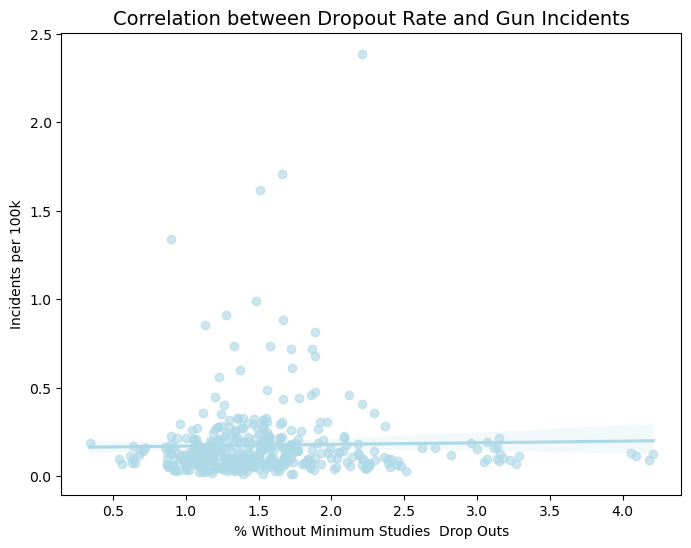

In [13]:
plt.figure(figsize=(8,6))
sns.regplot(
    data=df_top20_analysis,
    x="%Without_Min_Studies",
    y="Incidents_per_100k",
    color="lightblue",
    scatter_kws={'alpha':0.6}
)
plt.title("Correlation between Dropout Rate and Gun Incidents", fontsize=14)
plt.xlabel("% Without Minimum Studies  Drop Outs")
plt.ylabel("Incidents per 100k")
plt.show()

In [14]:
r, p = stats.pearsonr(
    df_top20_analysis["%Without_Min_Studies"].dropna(),
    df_top20_analysis["Incidents_per_100k"].dropna()
)

print(f"Pearson correlation: {r:.3f}")
print(f"p-value: {p:.4f}")

if p < 0.05:
    print(" Statistically significant correlation.")
else:
    print("No significant correlation found.")

Pearson correlation: 0.025
p-value: 0.6203
No significant correlation found.


No significant correlation found.


Drop outs HighSchool

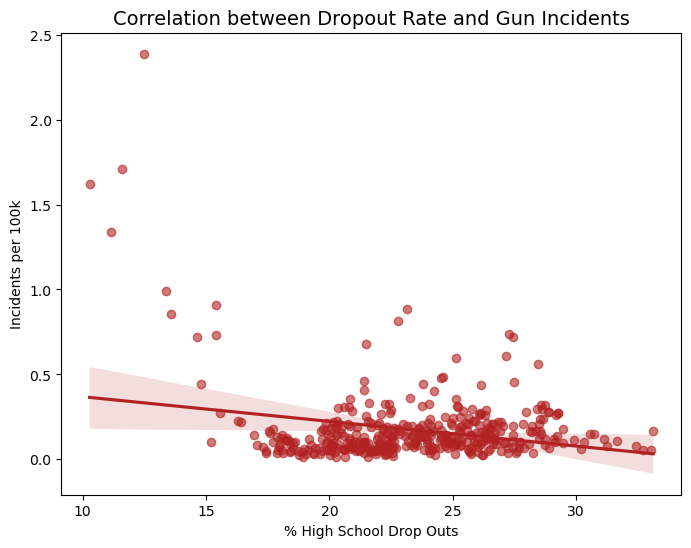

In [15]:
plt.figure(figsize=(8,6))
sns.regplot(
    data=df_top20_analysis,
    x="%HighSchool",
    y="Incidents_per_100k",
    color="firebrick",
    scatter_kws={'alpha':0.6}
)
plt.title("Correlation between Dropout Rate and Gun Incidents", fontsize=14)
plt.xlabel("% High School Drop Outs")
plt.ylabel("Incidents per 100k")
plt.show()

In [16]:
r, p = stats.pearsonr(
    df_top20_analysis["%HighSchool"].dropna(),
    df_top20_analysis["Incidents_per_100k"].dropna()
)

print(f"Pearson correlation: {r:.3f}")
print(f"p-value: {p:.4f}")

if p < 0.05:
    print("Statistically significant correlation.")
else:
    print("No significant correlation found.")

Pearson correlation: -0.251
p-value: 0.0000
Statistically significant correlation.


AS the drop out in HighSchool decreases, the number of incidents per 100 k  decreases

For drop outs in Bachelors

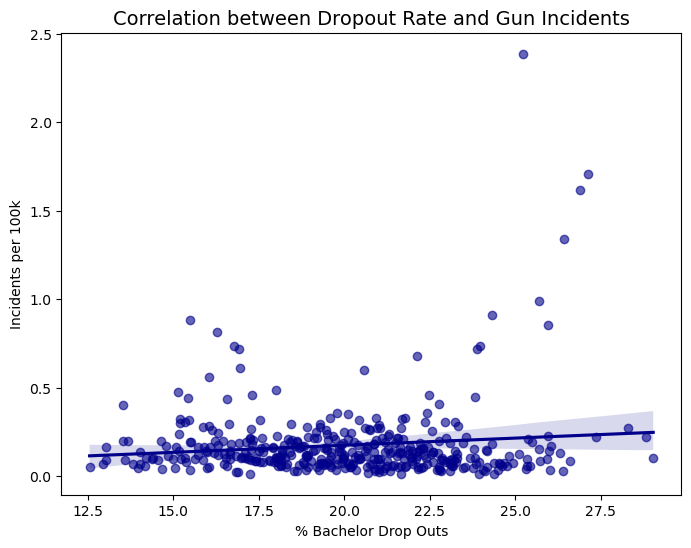

In [17]:
plt.figure(figsize=(8,6))
sns.regplot(
    data=df_top20_analysis,
    x="%Bachelor",
    y="Incidents_per_100k",
    color="darkblue",
    scatter_kws={'alpha':0.6}
)
plt.title("Correlation between Dropout Rate and Gun Incidents", fontsize=14)
plt.xlabel("% Bachelor Drop Outs")
plt.ylabel("Incidents per 100k")
plt.show()

In [18]:
r, p = stats.pearsonr(
    df_top20_analysis["%Bachelor"].dropna(),
    df_top20_analysis["Incidents_per_100k"].dropna()
)

print(f" Pearson correlation: {r:.3f}")
print(f" p-value: {p:.4f}")

if p < 0.05:
    print("Statistically significant correlation.")
else:
    print("No significant correlation found.")

 Pearson correlation: 0.120
 p-value: 0.0159
Statistically significant correlation.


AS the drop outs in Bachelors increases, the incidents per 100 k increases

Drop outs in Master Degrees

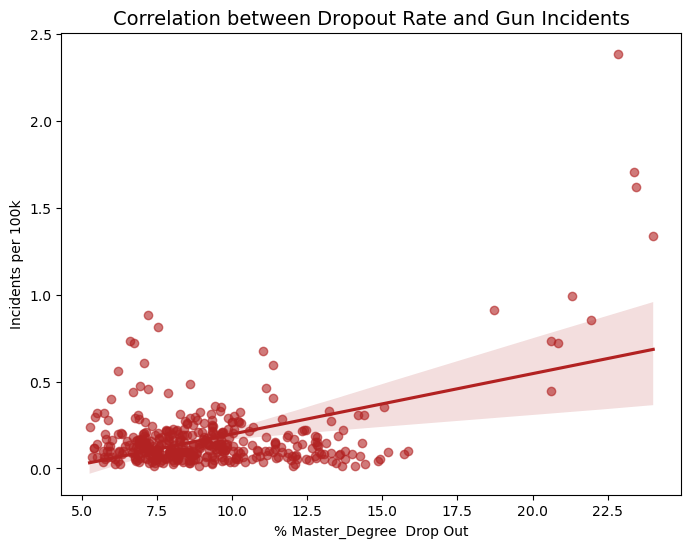

In [19]:
plt.figure(figsize=(8,6))
sns.regplot(
    data=df_top20_analysis,
    x="%Master_Degree",
    y="Incidents_per_100k",
    color="firebrick",
    scatter_kws={'alpha':0.6}
)
plt.title("Correlation between Dropout Rate and Gun Incidents", fontsize=14)
plt.xlabel("% Master_Degree  Drop Out")
plt.ylabel("Incidents per 100k")
plt.show()
plot_data = df_top20_analysis[["%Master_Degree", "Incidents_per_100k"]].dropna()

# Save them as CSV
plot_data.to_csv("master_vs_incidents.csv", index=False)

In [20]:
r, p = stats.pearsonr(
    df_top20_analysis["%Master_Degree"].dropna(),
    df_top20_analysis["Incidents_per_100k"].dropna()
)

print(f"🔹 Pearson correlation: {r:.3f}")
print(f"🔹 p-value: {p:.4f}")

if p < 0.05:
    print("Statistically significant correlation.")
else:
    print("No significant correlation found.")

🔹 Pearson correlation: 0.479
🔹 p-value: 0.0000
Statistically significant correlation.


As the drop outs in Masters degree increases, the incidents per 100 k increases


Doctorate Degree DropOuts

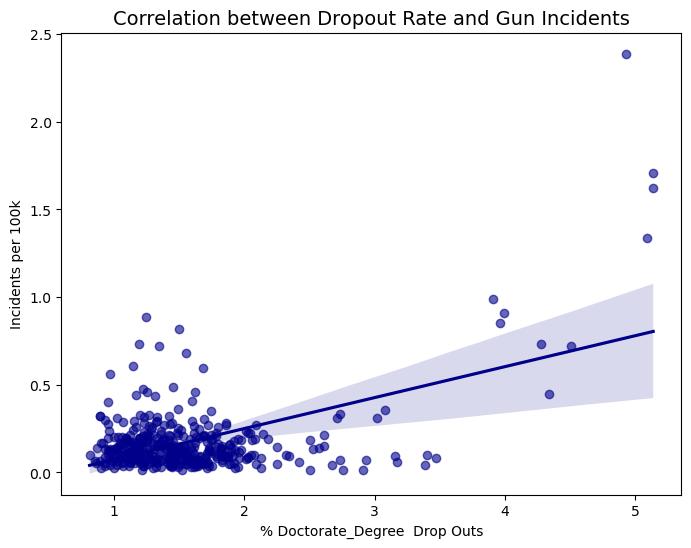

In [21]:
plt.figure(figsize=(8,6))
sns.regplot(
    data=df_top20_analysis,
    x="%Doctorate_Degree",
    y="Incidents_per_100k",
    color="darkblue",
    scatter_kws={'alpha':0.6}
)
plt.title("Correlation between Dropout Rate and Gun Incidents", fontsize=14)
plt.xlabel("% Doctorate_Degree  Drop Outs")
plt.ylabel("Incidents per 100k")
plt.show()

In [22]:
r, p = stats.pearsonr(
    df_top20_analysis["%Doctorate_Degree"].dropna(),
    df_top20_analysis["Incidents_per_100k"].dropna()
)

print(f"🔹 Pearson correlation: {r:.3f}")
print(f"🔹 p-value: {p:.4f}")

if p < 0.05:
    print("Statistically significant correlation.")
else:
    print("No significant correlation found.")

🔹 Pearson correlation: 0.534
🔹 p-value: 0.0000
Statistically significant correlation.


AS the drop outs in Doctrorate increases, the incidents per 100 k increases

Map with deadliest states

In [23]:

import plotly.express as px

# Compute averages by state
map_data = df_top20_analysis.groupby("State", as_index=False).agg({
    "Incidents_per_100k": "mean",
    "%Deadliest": "mean"
})

us_state_abbrev = {
    'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR','California': 'CA',
    'Colorado': 'CO','Connecticut': 'CT','Delaware': 'DE','District of Columbia': 'DC',
    'Florida': 'FL','Georgia': 'GA','Hawaii': 'HI','Idaho': 'ID','Illinois': 'IL',
    'Indiana': 'IN','Iowa': 'IA','Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA',
    'Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN',
    'Mississippi': 'MS','Missouri': 'MO','Montana': 'MT','Nebraska': 'NE','Nevada': 'NV',
    'New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY',
    'North Carolina': 'NC','North Dakota': 'ND','Ohio': 'OH','Oklahoma': 'OK','Oregon': 'OR',
    'Pennsylvania': 'PA','Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD',
    'Tennessee': 'TN','Texas': 'TX','Utah': 'UT','Vermont': 'VT','Virginia': 'VA',
    'Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY',
    'Puerto Rico': 'PR'
}

# Map full names to abbreviations
map_data["State_Code"] = map_data["State"].map(us_state_abbrev)


fig = px.choropleth(
    map_data,
    locations="State_Code",             
    locationmode="USA-states",
    color="Incidents_per_100k",
    hover_name="State",
    hover_data={"%Deadliest": True, "Incidents_per_100k": True},
    color_continuous_scale="Reds",
    scope="usa",
    title="Gun Incidents per 100k Population by State"
)
fig.show()

Mao n incidents and drop out highschool

In [24]:

import plotly.express as px

# Compute averages by state
map_data = df_top20_analysis.groupby("State", as_index=False).agg({
    "Incidents_per_100k": "mean",
    "%HighSchool": "mean"
})

us_state_abbrev = {
    'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR','California': 'CA',
    'Colorado': 'CO','Connecticut': 'CT','Delaware': 'DE','District of Columbia': 'DC',
    'Florida': 'FL','Georgia': 'GA','Hawaii': 'HI','Idaho': 'ID','Illinois': 'IL',
    'Indiana': 'IN','Iowa': 'IA','Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA',
    'Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN',
    'Mississippi': 'MS','Missouri': 'MO','Montana': 'MT','Nebraska': 'NE','Nevada': 'NV',
    'New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY',
    'North Carolina': 'NC','North Dakota': 'ND','Ohio': 'OH','Oklahoma': 'OK','Oregon': 'OR',
    'Pennsylvania': 'PA','Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD',
    'Tennessee': 'TN','Texas': 'TX','Utah': 'UT','Vermont': 'VT','Virginia': 'VA',
    'Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY',
    'Puerto Rico': 'PR'
}

# Map full names to abbreviations
map_data["State_Code"] = map_data["State"].map(us_state_abbrev)


fig = px.choropleth(
    map_data,
    locations="State_Code",             # use 2-letter codes
    locationmode="USA-states",
    color="Incidents_per_100k",
    hover_name="State",
    hover_data={"%HighSchool": True, "Incidents_per_100k": True},
    color_continuous_scale="Reds",
    scope="usa",
    title="Gun Incidents per 100k Population by State"
)
fig.show()

Map Drop Out Bachelor

In [25]:
map_data = df_top20_analysis.groupby("State", as_index=False).agg({
    "Incidents_per_100k": "mean",
    "%Bachelor": "mean"
})

us_state_abbrev = {
    'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR','California': 'CA',
    'Colorado': 'CO','Connecticut': 'CT','Delaware': 'DE','District of Columbia': 'DC',
    'Florida': 'FL','Georgia': 'GA','Hawaii': 'HI','Idaho': 'ID','Illinois': 'IL',
    'Indiana': 'IN','Iowa': 'IA','Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA',
    'Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN',
    'Mississippi': 'MS','Missouri': 'MO','Montana': 'MT','Nebraska': 'NE','Nevada': 'NV',
    'New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY',
    'North Carolina': 'NC','North Dakota': 'ND','Ohio': 'OH','Oklahoma': 'OK','Oregon': 'OR',
    'Pennsylvania': 'PA','Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD',
    'Tennessee': 'TN','Texas': 'TX','Utah': 'UT','Vermont': 'VT','Virginia': 'VA',
    'Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY',
    'Puerto Rico': 'PR'
}

# Map full names to abbreviations
map_data["State_Code"] = map_data["State"].map(us_state_abbrev)


fig = px.choropleth(
    map_data,
    locations="State_Code",             # use 2-letter codes
    locationmode="USA-states",
    color="Incidents_per_100k",
    hover_name="State",
    hover_data={"%Bachelor": True, "Incidents_per_100k": True},
    color_continuous_scale="Reds",
    scope="usa",
    title="Gun Incidents per 100k Population by State"
)
fig.show()

Master degree drop out map

In [26]:
map_data = df_top20_analysis.groupby("State", as_index=False).agg({
    "Incidents_per_100k": "mean",
    "%Master_Degree": "mean"
})

us_state_abbrev = {
    'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR','California': 'CA',
    'Colorado': 'CO','Connecticut': 'CT','Delaware': 'DE','District of Columbia': 'DC',
    'Florida': 'FL','Georgia': 'GA','Hawaii': 'HI','Idaho': 'ID','Illinois': 'IL',
    'Indiana': 'IN','Iowa': 'IA','Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA',
    'Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN',
    'Mississippi': 'MS','Missouri': 'MO','Montana': 'MT','Nebraska': 'NE','Nevada': 'NV',
    'New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY',
    'North Carolina': 'NC','North Dakota': 'ND','Ohio': 'OH','Oklahoma': 'OK','Oregon': 'OR',
    'Pennsylvania': 'PA','Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD',
    'Tennessee': 'TN','Texas': 'TX','Utah': 'UT','Vermont': 'VT','Virginia': 'VA',
    'Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY',
    'Puerto Rico': 'PR'
}

# Map full names to abbreviations
map_data["State_Code"] = map_data["State"].map(us_state_abbrev)


fig = px.choropleth(
    map_data,
    locations="State_Code",             # use 2-letter codes
    locationmode="USA-states",
    color="Incidents_per_100k",
    hover_name="State",
    hover_data={"%Master_Degree": True, "Incidents_per_100k": True},
    color_continuous_scale="Reds",
    scope="usa",
    title="Gun Incidents per 100k Population by State"
)
fig.show()

Doctorate Map

In [27]:
map_data = df_top20_analysis.groupby("State", as_index=False).agg({
    "Incidents_per_100k": "mean",
    "%Doctorate_Degree": "mean"
})

us_state_abbrev = {
    'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR','California': 'CA',
    'Colorado': 'CO','Connecticut': 'CT','Delaware': 'DE','District of Columbia': 'DC',
    'Florida': 'FL','Georgia': 'GA','Hawaii': 'HI','Idaho': 'ID','Illinois': 'IL',
    'Indiana': 'IN','Iowa': 'IA','Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA',
    'Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN',
    'Mississippi': 'MS','Missouri': 'MO','Montana': 'MT','Nebraska': 'NE','Nevada': 'NV',
    'New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY',
    'North Carolina': 'NC','North Dakota': 'ND','Ohio': 'OH','Oklahoma': 'OK','Oregon': 'OR',
    'Pennsylvania': 'PA','Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD',
    'Tennessee': 'TN','Texas': 'TX','Utah': 'UT','Vermont': 'VT','Virginia': 'VA',
    'Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY',
    'Puerto Rico': 'PR'
}

# Map full names to abbreviations
map_data["State_Code"] = map_data["State"].map(us_state_abbrev)


fig = px.choropleth(
    map_data,
    locations="State_Code",             # use 2-letter codes
    locationmode="USA-states",
    color="Incidents_per_100k",
    hover_name="State",
    hover_data={"%Doctorate_Degree": True, "Incidents_per_100k": True},
    color_continuous_scale="Reds",
    scope="usa",
    title="Gun Incidents per 100k Population by State"
)
fig.show()

In [28]:
import re
import requests
import pandas as pd
from io import StringIO
import os

URL = "https://en.wikipedia.org/wiki/List_of_United_States_presidential_election_results_by_state"
TARGET_YEARS = ["2012", "2016", "2020", "2024"]

HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/120.0.0.0 Safari/537.36"
}

FIFTY_STATES = {
    "Alabama","Alaska","Arizona","Arkansas","California","Colorado","Connecticut","Delaware","Florida",
    "Georgia","Hawaii","Idaho","Illinois","Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine",
    "Maryland","Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana","Nebraska",
    "Nevada","New Hampshire","New Jersey","New Mexico","New York","North Carolina","North Dakota",
    "Ohio","Oklahoma","Oregon","Pennsylvania","Rhode Island","South Carolina","South Dakota",
    "Tennessee","Texas","Utah","Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"
}

def normalize_party_value(val):
    if pd.isna(val): return None
    txt = str(val).strip()
    if txt == "D": return "Democratic"
    if txt == "R": return "Republican"
    if re.search(r"Democrat", txt, re.I): return "Democratic"
    if re.search(r"Republican", txt, re.I): return "Republican"
    if re.fullmatch(r"[dD]", txt): return "Democratic"
    if re.fullmatch(r"[rR]", txt): return "Republican"
    return txt

def normalize_state(s):
    if s is None: return ""
    return re.sub(r"\[[^\]]+\]", "", str(s)).strip()

html = requests.get(URL, headers=HEADERS).text
tables = pd.read_html(StringIO(html), flavor="lxml", header=0)

table = None
for t in tables:
    cols = " ".join(map(str, t.columns))
    if "2012" in cols and "2024" in cols:
        table = t
        break

if table is not None:
    table.columns = [str(c).strip() for c in table.columns]
    state_col = next((c for c in table.columns if "State" in c or "state" in c), table.columns[0])
    sub = table[[state_col] + [c for c in table.columns if any(y in str(c) for y in TARGET_YEARS)]].copy()
    sub.columns = ["State"] + TARGET_YEARS
    sub["State"] = sub["State"].map(normalize_state)
    sub = sub[sub["State"].isin(FIFTY_STATES)].copy()
    for y in TARGET_YEARS:
        sub[y] = sub[y].map(normalize_party_value)
    sub = sub.sort_values("State").reset_index(drop=True)

    duplicate_map = {
        "2013": "2012", "2014": "2012", "2015": "2012",
        "2017": "2016", "2018": "2016", "2019": "2016",
        "2021": "2020", "2022": "2020", "2023": "2020",
        "2025": "2024",
    }
    for new_year, base_year in duplicate_map.items():
        sub[new_year] = sub[base_year]

    FULL_YEARS = [str(y) for y in range(2012, 2026)]
    sub = sub[["State"] + FULL_YEARS]

    def tendency(row):
        reps = sum(row[y] == "Republican" for y in TARGET_YEARS)
        dems = sum(row[y] == "Democratic" for y in TARGET_YEARS)
        if reps > dems:  return "Republican"
        if dems > reps:  return "Democratic"
        return "Tie"

    sub["Tendency"] = sub.apply(tendency, axis=1)

    TOTAL_STATES = len(sub)
    winners_row = {"State": "Winner by year", "Tendency": ""}
    perc_row    = {"State": "Percentages",   "Tendency": ""}

    for y in FULL_YEARS:
        r = (sub[y] == "Republican").sum()
        d = (sub[y] == "Democratic").sum()
        winners_row[y] = "Republican" if r > d else ("Democratic" if d > r else "Tie")
        perc_row[y]    = f"R:{r/TOTAL_STATES*100:.1f}% / D:{d/TOTAL_STATES*100:.1f}%"

    blank_row = {col: "" for col in sub.columns}
    final = pd.concat([sub, pd.DataFrame([blank_row, winners_row, perc_row])], ignore_index=True)

    us_presidential_results = final.copy()

    pd.set_option("display.width", None)
    pd.set_option("display.max_columns", None)
    print(us_presidential_results.head(10))

         State        2012        2013        2014        2015        2016  \
0      Alabama  Republican  Republican  Republican  Republican  Republican   
1       Alaska  Republican  Republican  Republican  Republican  Republican   
2      Arizona  Republican  Republican  Republican  Republican  Republican   
3     Arkansas  Republican  Republican  Republican  Republican  Republican   
4   California  Democratic  Democratic  Democratic  Democratic  Democratic   
5     Colorado  Democratic  Democratic  Democratic  Democratic  Democratic   
6  Connecticut  Democratic  Democratic  Democratic  Democratic  Democratic   
7     Delaware  Democratic  Democratic  Democratic  Democratic  Democratic   
8      Florida  Democratic  Democratic  Democratic  Democratic  Republican   
9      Georgia  Republican  Republican  Republican  Republican  Republican   

         2017        2018        2019        2020        2021        2022  \
0  Republican  Republican  Republican  Republican  Republican  R

In [29]:
import pandas as pd
import numpy as np
import re

try:
    us_presidential_results
except NameError:
    raise RuntimeError(
        "DataFrame 'us_presidential_results' do not exist"
    )

df = pd.read_csv('gva_mass_shootings-2025-10-21.csv')

def norm_state(s):
    if pd.isna(s):
        return ""
    s = re.sub(r"\[[^\]]+\]", "", str(s)).strip()
    s = s.replace("Washington, D.C.", "Washington").replace("D.C.", "Washington")
    if s == "District of Columbia":
        s = "Washington"
    return s

year_cols = [c for c in us_presidential_results.columns if str(c).isdigit() and 2012 <= int(c) <= 2025]

elections_long = (
    us_presidential_results
    .loc[:, ["State"] + year_cols]
    .melt(id_vars=["State"], value_vars=year_cols,
          var_name="Year", value_name="PresidentialResult")
    .dropna(subset=["PresidentialResult"])
)
elections_long["Year"] = elections_long["Year"].astype(int)
elections_long["_state_key"] = elections_long["State"].map(norm_state).str.lower()

pres_map = (
    elections_long
    .set_index(["_state_key", "Year"])["PresidentialResult"]
    .to_dict()
)

state_col = next((c for c in df.columns if "state" in c.lower()), None)
if state_col is None:
    raise ValueError("No found column in CSV.")

year_col = next((c for c in df.columns if c.lower() == "year"), None)
if year_col is None:
    date_col = next((c for c in df.columns if "date" in c.lower()), None)
    if date_col is None:
        raise ValueError("No year no date.")
    year_aux = pd.to_datetime(df[date_col], errors="coerce").dt.year.astype("Int64")
else:
    year_aux = pd.to_numeric(df[year_col], errors="coerce").astype("Int64")

_state_key = df[state_col].map(norm_state).str.lower()
_year_key  = year_aux

df["PresidentialResult"] = [
    pres_map.get((s, int(y)) if pd.notna(y) else (s, y), np.nan)
    for s, y in zip(_state_key, _year_key)
]

df_merged = df.copy()

cols_to_show = [state_col]
if year_col:
    cols_to_show.append(year_col)
cols_to_show.append("PresidentialResult")
print(df_merged[cols_to_show].head(10))

            state  year PresidentialResult
0         Florida  2017         Republican
1        Oklahoma  2017         Republican
2      California  2017         Democratic
3        Michigan  2018         Republican
4         Alabama  2018         Republican
5  South Carolina  2022         Republican
6        Maryland  2023         Democratic
7       Louisiana  2024         Republican
8        Michigan  2024         Republican
9       Wisconsin  2016         Republican


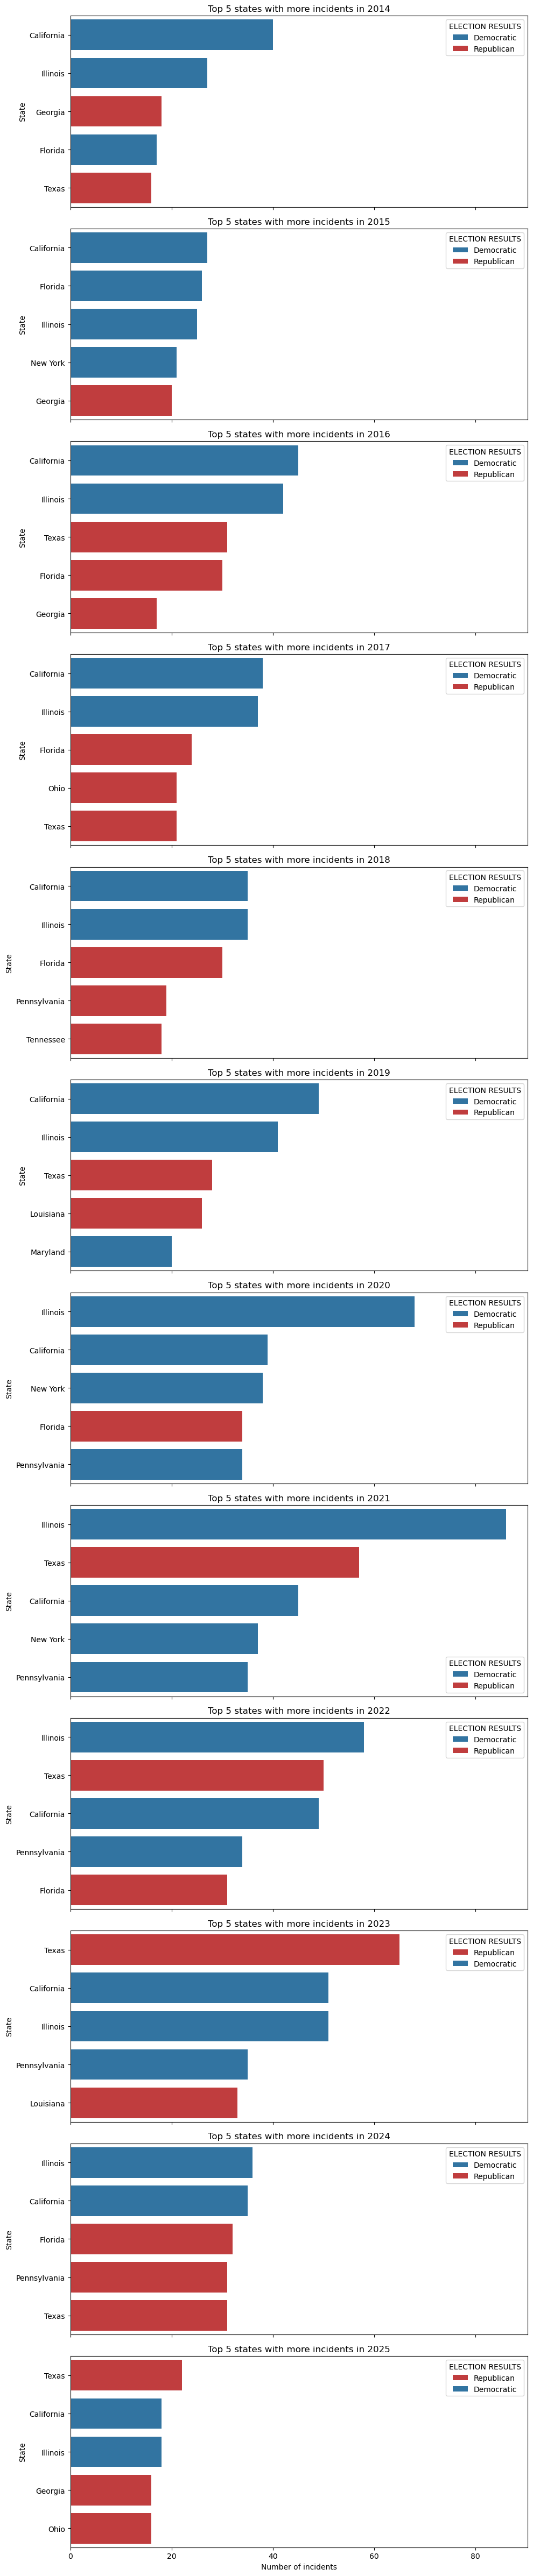

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

state_col = next((c for c in df_merged.columns if "state" in c.lower()), None)
if state_col is None:
    raise ValueError("Non value")

if "year" not in df_merged.columns and "Year" in df_merged.columns:
    df_merged = df_merged.rename(columns={"Year": "year"})

if "year" not in df_merged.columns:
    raise ValueError("Non value")

df_plot = df_merged.copy()
df_plot["year"] = pd.to_numeric(df_plot["year"], errors="coerce")
df_plot = df_plot.dropna(subset=["year"])
df_plot["year"] = df_plot["year"].astype(int)

incident_counts = (
    df_plot.groupby(["year", state_col, "PresidentialResult"])
           .size()
           .reset_index(name="Incidents")
)

party_palette = {
    "Democratic": "#1f77b4",   
    "Republican": "#d62728",  
    "Tie": "gray"
}

years = sorted(incident_counts["year"].unique())

fig, axes = plt.subplots(len(years), 1, figsize=(10, 4 * len(years)), sharex=True)

if len(years) == 1:
    axes = [axes]

for i, yr in enumerate(years):
    subset = (
        incident_counts[incident_counts["year"] == yr]
        .nlargest(5, "Incidents")
    )
    sns.barplot(
        data=subset,
        x="Incidents",
        y=state_col,
        hue="PresidentialResult",
        ax=axes[i],
        dodge=False,
        palette=party_palette
    )
    axes[i].set_title(f"Top 5 states with more incidents in {yr}")
    axes[i].set_xlabel("Number of incidents")
    axes[i].set_ylabel("State")
    axes[i].legend(title="ELECTION RESULTS", loc="best")

plt.tight_layout()
plt.show()

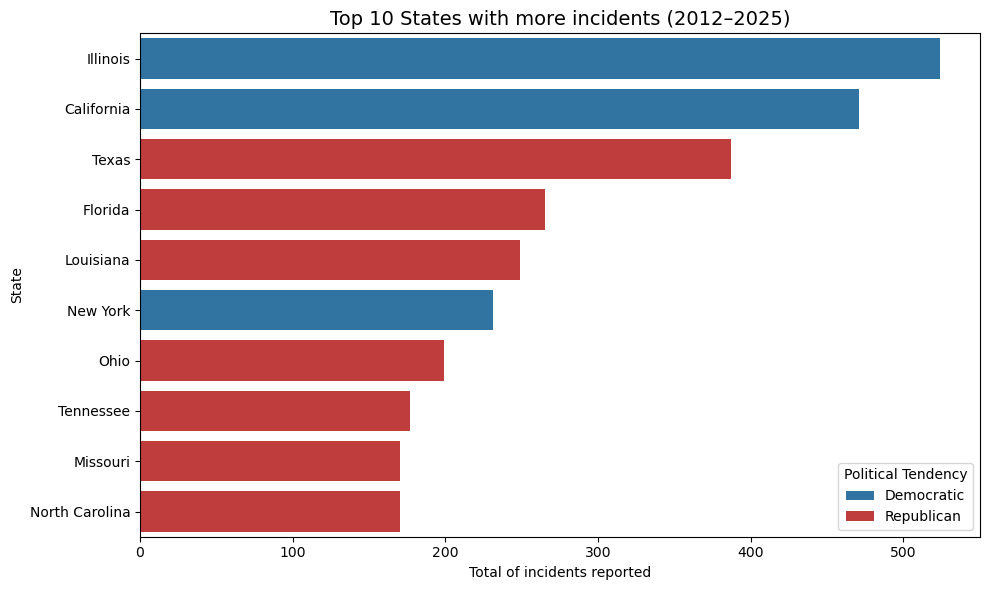

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

state_totals = (
    df_merged.groupby(["state", "PresidentialResult"])
             .size()
             .reset_index(name="TotalIncidents")
)

top10 = state_totals.nlargest(10, "TotalIncidents")

party_palette = {
    "Democratic": "#1f77b4",   # azul
    "Republican": "#d62728",   # rojo
    "Tie": "gray"
}

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top10,
    x="TotalIncidents",
    y="state",
    hue="PresidentialResult",
    dodge=False,
    palette=party_palette
)
plt.title("Top 10 States with more incidents (2012–2025)", fontsize=14)
plt.xlabel("Total of incidents reported")
plt.ylabel("State")
plt.legend(title="Political Tendency")
plt.tight_layout()
plt.show()

In [32]:
import pandas as pd
import plotly.express as px
import re
import numpy as np

state_col = next((c for c in df_merged.columns if "state" in c.lower()), None)
if state_col is None:
    raise ValueError("No column state foun in df_merged.")

if "year" not in df_merged.columns and "Year" in df_merged.columns:
    df_merged = df_merged.rename(columns={"Year": "year"})

def norm_state(s):
    if pd.isna(s):
        return ""
    s = re.sub(r"\[[^\]]+\]", "", str(s)).strip()
    s = s.replace("Washington, D.C.", "Washington").replace("D.C.", "Washington")
    if s == "District of Columbia":
        s = "Washington"
    return s

tmp = df_merged.copy()
tmp["_StateNorm"] = tmp[state_col].map(norm_state)

state_totals = (
    tmp.groupby(["_StateNorm", "PresidentialResult"])
       .size()
       .reset_index(name="TotalIncidents")
)

predominant = (
    state_totals.sort_values(["_StateNorm", "TotalIncidents"], ascending=[True, False])
                .drop_duplicates(subset=["_StateNorm"])
                .rename(columns={"PresidentialResult": "Party"})
)

STATE_TO_ABBR = {
    "Alabama":"AL","Alaska":"AK","Arizona":"AZ","Arkansas":"AR","California":"CA","Colorado":"CO",
    "Connecticut":"CT","Delaware":"DE","Florida":"FL","Georgia":"GA","Hawaii":"HI","Idaho":"ID",
    "Illinois":"IL","Indiana":"IN","Iowa":"IA","Kansas":"KS","Kentucky":"KY","Louisiana":"LA",
    "Maine":"ME","Maryland":"MD","Massachusetts":"MA","Michigan":"MI","Minnesota":"MN",
    "Mississippi":"MS","Missouri":"MO","Montana":"MT","Nebraska":"NE","Nevada":"NV",
    "New Hampshire":"NH","New Jersey":"NJ","New Mexico":"NM","New York":"NY","North Carolina":"NC",
    "North Dakota":"ND","Ohio":"OH","Oklahoma":"OK","Oregon":"OR","Pennsylvania":"PA",
    "Rhode Island":"RI","South Carolina":"SC","South Dakota":"SD","Tennessee":"TN","Texas":"TX",
    "Utah":"UT","Vermont":"VT","Virginia":"VA","Washington":"WA","West Virginia":"WV",
    "Wisconsin":"WI","Wyoming":"WY"
}

predominant["state_code"] = predominant["_StateNorm"].map(STATE_TO_ABBR)

party_colors = {
    "Democratic": "blue",
    "Republican": "red",
    "Tie": "gray"
}

map_df = predominant.dropna(subset=["state_code"]).copy()

fig = px.choropleth(
    map_df,
    locations="state_code",
    locationmode="USA-states",
    color="Party",
    hover_name="_StateNorm",
    hover_data={"TotalIncidents": True, "state_code": False, "Party": True},
    color_discrete_map=party_colors,
    scope="usa",
    title="Total Incidents 2012–2025 per State and Predominant Party"
)
fig.update_layout(
    geo=dict(bgcolor="rgba(0,0,0,0)"),
    title_x=0.5
)
fig.show()

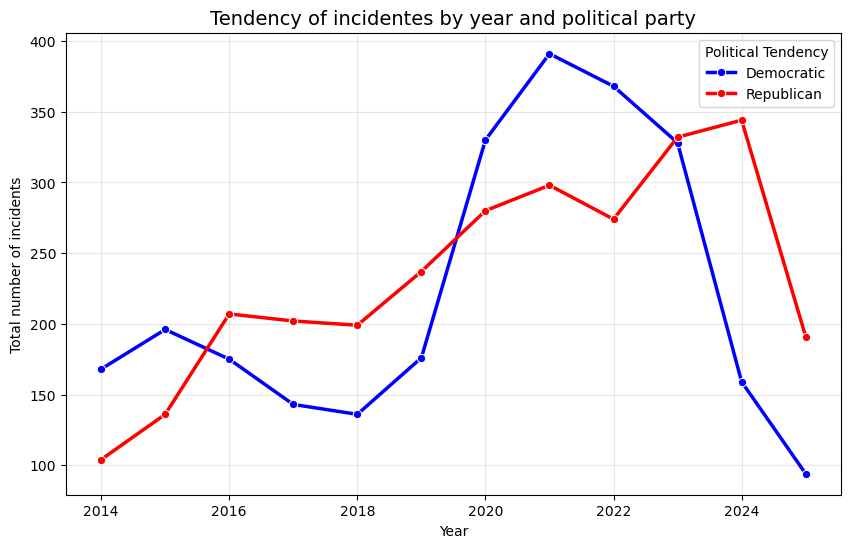

In [33]:
line_data = (
    df_merged.groupby(["year", "PresidentialResult"])
    .size()
    .reset_index(name="Incidents")
)

plt.figure(figsize=(10,6))
sns.lineplot(
    data=line_data,
    x="year",
    y="Incidents",
    hue="PresidentialResult",
    palette={"Democratic": "blue", "Republican": "red"},
    linewidth=2.5,
    marker="o"
)

plt.title("Tendency of incidentes by year and political party", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Total number of incidents")
plt.legend(title="Political Tendency")
plt.grid(alpha=0.3)
plt.show()

In [34]:
pip install nbmerge

Note: you may need to restart the kernel to use updated packages.


In [35]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
import scipy.stats as stats
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Polygon
import missingno as msno
import os
import wget
import openpyxl
import math

from scipy.stats import stats

In [36]:
df = pd.read_csv('gva_mass_shootings-2025-10-21.csv')
df

,incident_id,incident_date,incident_time,updated_date,state,city_or_county,address,business_location_name,latitude,longitude,killed,injured,victims_killed,victims_injured,suspects_killed,suspects_injured,suspects_arrested,incident_characteristics,sources,date_fixed,year
0,809048,"April 1, 2017",NaN,1491348530,Florida,Tampa,219 S Howard Ave,Palace Lounge,27.9431,-82.4831,1,4,1,4,0,0,1,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""http://wfla.com/2017/04/01/tampa-police-inv...",2017-04-01,2017
1,809499,"April 1, 2017",5:25 AM,1680156402,Oklahoma,Oklahoma City,1212 N Woodward Ave,NaN,35.4810,-97.5754,2,3,2,3,0,0,1,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""http://www.news9.com/story/35055747/okc-pol...",2017-04-01,2017
2,809815,"April 1, 2017",NaN,1492995601,California,Pittsburg,100 block of Madoline Street,NaN,38.0053,-121.8950,0,5,0,5,0,0,1,"Shot - Wounded/Injured, Mass Shooting (4+ vict...",http://www.nbcbayarea.com/news/local/Shooting-...,2017-04-01,2017
3,1082835,"April 1, 2018",2:15 AM,1522693801,Michigan,Saginaw,600 block of Yale St,NaN,43.4192,-83.9819,0,5,0,5,0,0,0,"Shot - Wounded/Injured, Mass Shooting (4+ vict...",http://www.mlive.com/news/saginaw/index.ssf/20...,2018-04-01,2018
4,1083011,"April 1, 2018",NaN,1646889853,Alabama,Mobile,3556 Halls Mill Rd,Grand Hall,30.6387,-88.1228,1,4,1,4,0,0,3,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""http://www.al.com/news/mobile/index.ssf/201...",2018-04-01,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5463,2411007,"September 9, 2022",4:50 PM,1722738993,New York,Bronx,810 Astor Ave,Pelham Parkway Houses,40.8592,-73.8634,0,4,0,4,0,0,1,"Shot - Wounded/Injured, Mass Shooting (4+ vict...","c(""https://twitter.com/NYC_Alerts911/status/15...",2022-09-09,2022
5464,2411901,"September 9, 2022",11:50 PM,1689272621,Minnesota,Minneapolis,328 W Broadway Ave,4th Street Saloon,44.9994,-93.2848,1,3,1,3,0,0,0,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""https://www.fox9.com/news/2-pregnant-women-...",2022-09-09,2022
5465,2410446,"September 9, 2022",9:00 AM,1715920831,Maryland,Elk Mills,47 Hebron Ct,NaN,39.6611,-75.8365,5,0,4,0,1,0,0,"Shot - Dead (murder, accidental, or suicide), ...","c(""https://www.cbsnews.com/baltimore/news/five...",2022-09-09,2022
5466,2703975,"September 9, 2023",11:30 PM,1694472936,South Carolina,Rock Hill,800 block of Brunswick Dr,NaN,34.8921,-81.0411,0,4,0,4,0,0,2,"Shot - Wounded/Injured, Mass Shooting (4+ vict...",https://www.heraldonline.com/news/local/crime/...,2023-09-09,2023


In [37]:
# Add csv for gini coefficient by yearSplit first row by ;, and unify column names to lowercase with underscores
df2 = pd.read_csv("gini.csv", sep=';')
df2 = df2.rename(columns={'Unnamed: 3': 'gini_coefficient'})
df2.columns = [c.lower().replace(' ', '_') for c in df2.columns]

# Updating name of DC to match in both dataframes
df2['state'].replace({"Dist. of Columbia": "District of Columbia"}, inplace=True)

# Merging dataframes on year and state
df_merged = pd.merge(left = df, right = df2, left_on=['year', 'state'], right_on=['year', 'state'], how='left')

# Deleting unnecessary index column from right dataframe
del df_merged['unnamed:_0']

# Clean gini_coefficient column by multiplying numbers above 1 by 0.001 (Gini coefficient should be between 0 and 1)
df_merged['gini_coefficient'] = df_merged['gini_coefficient'].apply(lambda x: x * 0.001 if x > 1 else x)

# Getting the mean gini coefficient by state
df_gini_mean = df_merged.groupby('state')['gini_coefficient'].mean()

# Updating all states missing gini coefficient with the mean gini coefficient of that state
for state in df_gini_mean.index:
    mean_gini = df_gini_mean[state]
    df_merged["gini_coefficient"].fillna(value=mean_gini, inplace=True)

# Adding link of Wikipedia page for poverty in each state, and preparing for web scraping
url = "https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_poverty_rate#cite_note-CensusData-1"
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"}
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content)
table = soup.find("tbody")

# Defining labels for dataframe:
labels = [label.get_text() for label in table.find_all("a")]

# Getting values for dataframe:
values = table.find_all("td")
list_values = values[1:len(values):5]
for values in list_values:
    value = float(values.get_text().replace("\n",""))


# Iterating through labels and values to create a dataframe
poverty_data = {}
for key, value in zip(labels, list_values):
    poverty_data[key] = value

# Create dataframe for poverty levels in different states
df_poverty = pd.DataFrame.from_dict(poverty_data, orient='index', columns=['poverty_rate_2025'])

# Updating states with column for poverty rates in states in 2025 and making the poverty rate a float
df_merged = pd.merge(left=df_merged, right=df_poverty, left_on='state', right_index=True, how='left')
df_merged['poverty_rate_2025'] = df_merged['poverty_rate_2025'].astype(float)
df_merged

/var/folders/wc/048rx86x7bqbzmjn7nr46j_80000gn/T/ipykernel_57911/1849478275.py:7: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/var/folders/wc/048rx86x7bqbzmjn7nr46j_80000gn/T/ipykernel_57911/1849478275.py:24: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 

,incident_id,incident_date,incident_time,updated_date,state,city_or_county,address,business_location_name,latitude,longitude,killed,injured,victims_killed,victims_injured,suspects_killed,suspects_injured,suspects_arrested,incident_characteristics,sources,date_fixed,year,gini_coefficient,poverty_rate_2025
0,809048,"April 1, 2017",NaN,1491348530,Florida,Tampa,219 S Howard Ave,Palace Lounge,27.9431,-82.4831,1,4,1,4,0,0,1,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""http://wfla.com/2017/04/01/tampa-police-inv...",2017-04-01,2017,0.4859,12.3
1,809499,"April 1, 2017",5:25 AM,1680156402,Oklahoma,Oklahoma City,1212 N Woodward Ave,NaN,35.4810,-97.5754,2,3,2,3,0,0,1,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""http://www.news9.com/story/35055747/okc-pol...",2017-04-01,2017,0.4658,15.9
2,809815,"April 1, 2017",NaN,1492995601,California,Pittsburg,100 block of Madoline Street,NaN,38.0053,-121.8950,0,5,0,5,0,0,1,"Shot - Wounded/Injured, Mass Shooting (4+ vict...",http://www.nbcbayarea.com/news/local/Shooting-...,2017-04-01,2017,0.4866,12.0
3,1082835,"April 1, 2018",2:15 AM,1522693801,Michigan,Saginaw,600 block of Yale St,NaN,43.4192,-83.9819,0,5,0,5,0,0,0,"Shot - Wounded/Injured, Mass Shooting (4+ vict...",http://www.mlive.com/news/saginaw/index.ssf/20...,2018-04-01,2018,0.4679,13.5
4,1083011,"April 1, 2018",NaN,1646889853,Alabama,Mobile,3556 Halls Mill Rd,Grand Hall,30.6387,-88.1228,1,4,1,4,0,0,3,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""http://www.al.com/news/mobile/index.ssf/201...",2018-04-01,2018,0.4859,15.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5463,2411007,"September 9, 2022",4:50 PM,1722738993,New York,Bronx,810 Astor Ave,Pelham Parkway Houses,40.8592,-73.8634,0,4,0,4,0,0,1,"Shot - Wounded/Injured, Mass Shooting (4+ vict...","c(""https://twitter.com/NYC_Alerts911/status/15...",2022-09-09,2022,0.5208,14.2
5464,2411901,"September 9, 2022",11:50 PM,1689272621,Minnesota,Minneapolis,328 W Broadway Ave,4th Street Saloon,44.9994,-93.2848,1,3,1,3,0,0,0,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""https://www.fox9.com/news/2-pregnant-women-...",2022-09-09,2022,0.4560,9.3
5465,2410446,"September 9, 2022",9:00 AM,1715920831,Maryland,Elk Mills,47 Hebron Ct,NaN,39.6611,-75.8365,5,0,4,0,1,0,0,"Shot - Dead (murder, accidental, or suicide), ...","c(""https://www.cbsnews.com/baltimore/news/five...",2022-09-09,2022,0.4589,9.5
5466,2703975,"September 9, 2023",11:30 PM,1694472936,South Carolina,Rock Hill,800 block of Brunswick Dr,NaN,34.8921,-81.0411,0,4,0,4,0,0,2,"Shot - Wounded/Injured, Mass Shooting (4+ vict...",https://www.heraldonline.com/news/local/crime/...,2023-09-09,2023,0.4715,13.9


In [38]:
# total of killed, injured and total victims by state:
df_state_summary = df_merged.groupby('state').agg({'killed': 'sum', 'injured': 'sum'})
df_state_summary["total_victims"] = df_state_summary['killed'] + df_state_summary['injured']
df_state_summary["gini_coefficient"] = df_merged.groupby('state')['gini_coefficient'].mean()
df_state_summary["mass_shootings_count"] = df_merged.groupby('state')['year'].count()
df_state_summary["poverty_rate_2025"] = df_merged.groupby('state')['poverty_rate_2025'].mean()
df_state_summary

,killed,injured,total_victims,gini_coefficient,mass_shootings_count,poverty_rate_2025
state,,,,,,
Alabama,163,635,798,0.481598,145,15.6
Alaska,8,20,28,0.464265,6,10.4
Arizona,88,246,334,0.468690,61,12.4
Arkansas,67,297,364,0.478161,62,15.7
California,552,1873,2425,0.488129,471,12.0
Colorado,117,345,462,0.463406,87,9.3
Connecticut,15,154,169,0.491554,35,10.3
Delaware,13,81,94,0.462499,21,10.5
District of Columbia,56,392,448,0.512948,90,14.0


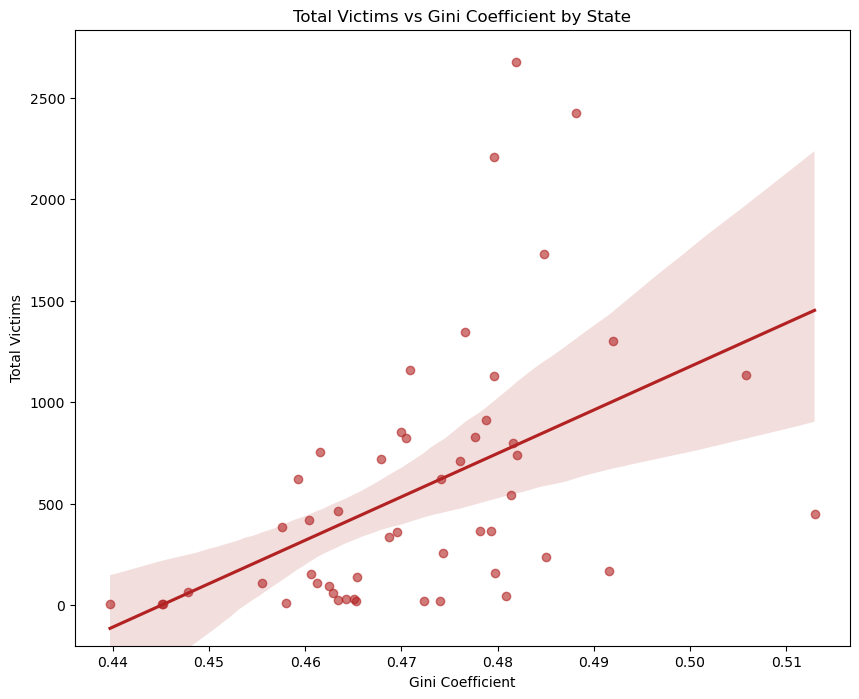

In [39]:
plt.figure(figsize=(10,8))
sns.regplot(
    data=df_state_summary,
    x="gini_coefficient",
    y="total_victims",
    color="firebrick",
    scatter_kws={'alpha':0.6}
)
plt.title("Total Victims vs Gini Coefficient by State", fontsize=12)
plt.xlabel("Gini Coefficient")
plt.ylabel("Total Victims")
plt.ylim(-200)
plt.show()

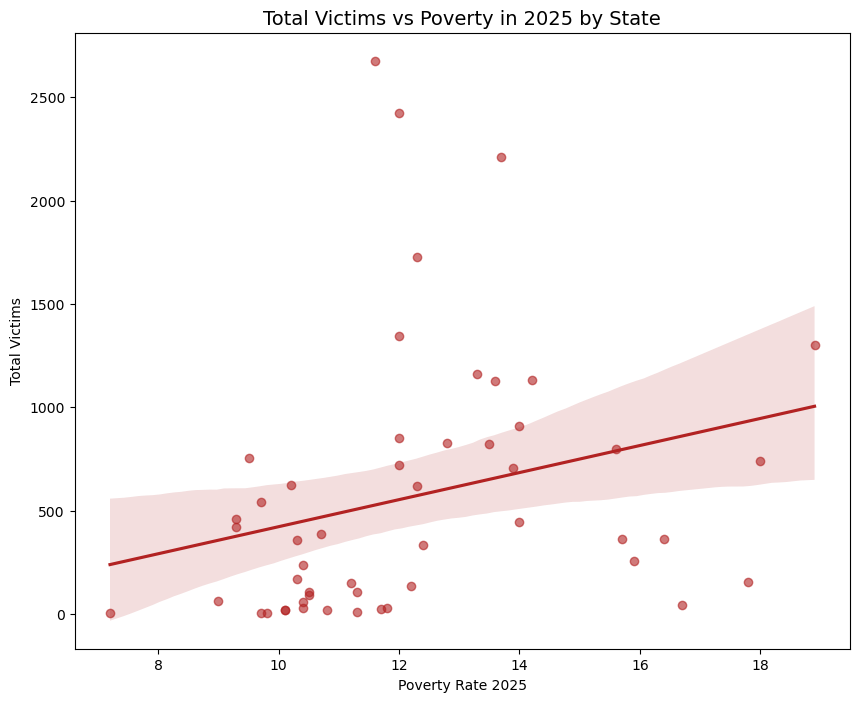

In [40]:
plt.figure(figsize=(10,8))
sns.regplot(
    data=df_state_summary,
    x="poverty_rate_2025",
    y="total_victims",
    color="firebrick",
    scatter_kws={'alpha':0.6}
)
plt.title("Total Victims vs Poverty in 2025 by State", fontsize=14)
plt.xlabel("Poverty Rate 2025")
plt.ylabel("Total Victims")
plt.show()

In [41]:
# count of shootings by state
df_shooting_counts = df_merged['state'].value_counts().reset_index()
df_shooting_counts.columns = ['state', 'shooting_counts']
df_shooting_counts

,state,shooting_counts
0,Illinois,524
1,California,471
2,Texas,387
3,Florida,308
4,Pennsylvania,271
5,Louisiana,249
6,New York,231
7,Georgia,225
8,Ohio,219
9,Tennessee,177


/opt/anaconda3/lib/python3.13/site-packages/pyproj/crs/crs.py:143: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

/opt/anaconda3/lib/python3.13/site-packages/pyproj/crs/crs.py:143: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

/var/folders/wc/048rx86x7bqbzmjn7nr46j_80000gn/T/ipykernel_57911/1932112675.py:95: UserWarning:

Only specify one of 'column' or 'color'. Using 'color'.



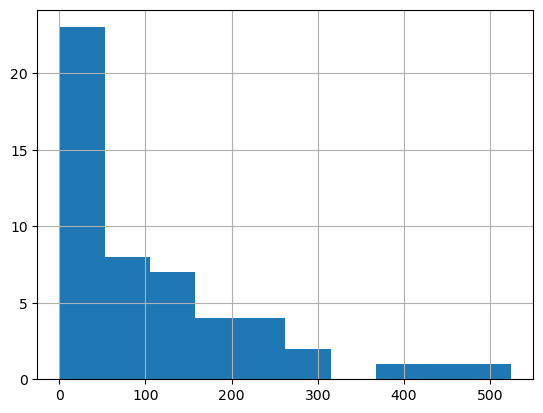

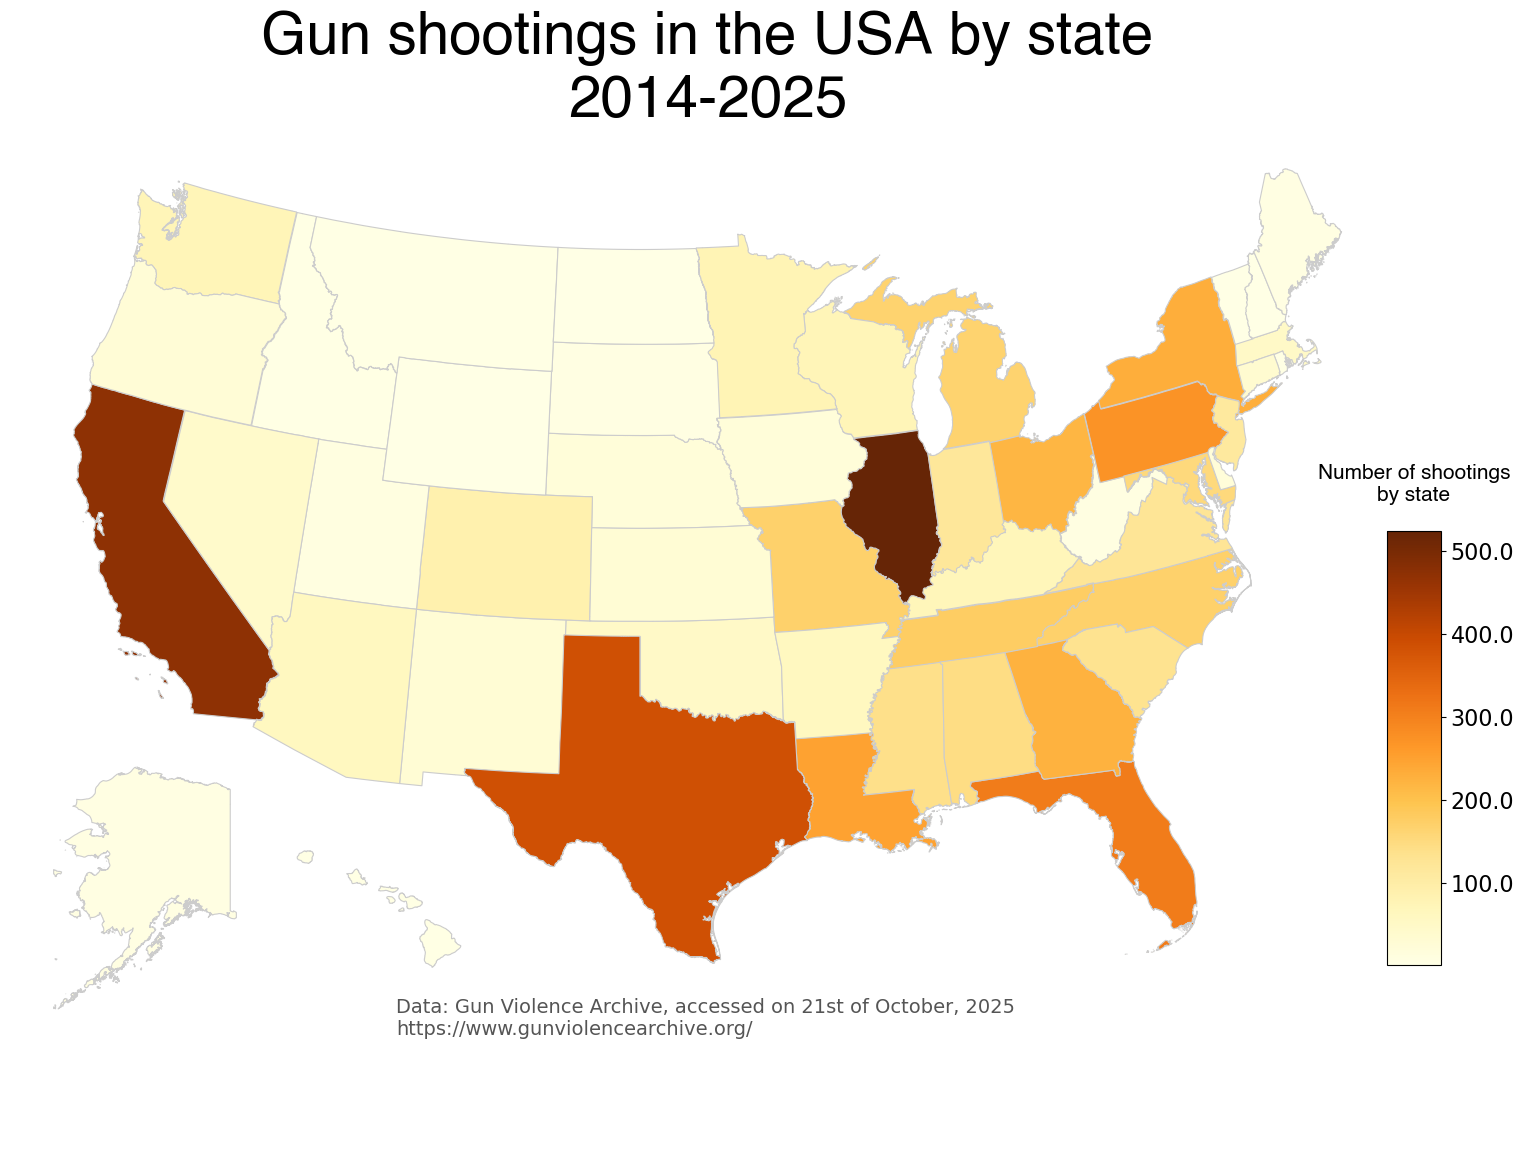

In [42]:
# Creating a dataframe for geodata
df_geo = df_shooting_counts[["state", "shooting_counts"]]

# Getting the geospatial files from geopandas and merging 
df_geo.shooting_counts.hist()

gdf = gpd.read_file(os.getcwd()+'/cb_2018_us_state_500k')

gdf = gdf.merge(df_shooting_counts,left_on='NAME',right_on='state')

# Creating a copy of gdf for re-projecting
gdf.to_crs({'init':'epsg:2163'})


# Apply this to the gdf to ensure all states are assigned colors by the same func

def makeColorColumn(gdf,variable,vmin,vmax):

    # apply a function to a column to create a new column of assigned colors & return full frame
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.YlOrBr)
    gdf['value_determined_color'] = gdf[variable].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
    return gdf

# **************************
# set the value column that will be visualised
variable = 'shooting_counts'

# make a column for value_determined_color in gdf
# set the range for the choropleth values with the upper bound the rounded up maximum value
vmin, vmax = gdf.shooting_counts.min(), gdf.shooting_counts.max() #math.ceil(gdf.shooting_counts.max())
# Choose the continuous colorscale "YlOrBr" from https://matplotlib.org/stable/tutorials/colors/colormaps.html
colormap = "YlOrBr"
gdf = makeColorColumn(gdf,variable,vmin,vmax)

# create "visframe" as a re-projected gdf using EPSG 2163 for CONUS
visframe = gdf.to_crs({'init':'epsg:2163'})

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(18, 14))
# remove the axis box around the vis
ax.axis('off')

# set the font for the visualization to Helvetica
hfont = {'fontname':'Helvetica'}

# add a title and annotation
ax.set_title('Gun shootings in the USA by state\n2014-2025', **hfont, fontdict={'fontsize': '42', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
# add colorbar axes to the figure
# This will take some iterating to get it where you want it [l,b,w,h] right
# l:left, b:bottom, w:width, h:height; in normalized unit (0-1)
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])   

cbax.set_title('Number of shootings\nby state\n', **hfont, fontdict={'fontsize': '15', 'fontweight' : '0'})

# add color scale
sm = plt.cm.ScalarMappable(cmap=colormap, \
                 norm=plt.Normalize(vmin=vmin, vmax=vmax))
# reformat tick labels on legend
sm._A = []
comma_fmt = FuncFormatter(lambda x, p: format(x))
fig.colorbar(sm, cax=cbax, format=comma_fmt)
tick_font_size = 16
cbax.tick_params(labelsize=tick_font_size)
# annotate the data source, date of access, and hyperlink
ax.annotate("Data: Gun Violence Archive, accessed on 21st of October, 2025\nhttps://www.gunviolencearchive.org/", xy=(0.22, .085), xycoords='figure fraction', fontsize=14, color='#555555')


# create map
# Note: we're going state by state here because of unusual coloring behavior when trying to plot the entire dataframe using the "value_determined_color" column
for row in visframe.itertuples():
    if row.state not in ['Alaska','Hawaii']:
        vf = visframe[visframe.state==row.state]
        c = gdf[gdf.state==row.state][0:1].value_determined_color.item()
        vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='0.8')

# add Alaska
akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
akax.axis('off')
# polygon to clip western islands
polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska_gdf = gdf[gdf.state=='Alaska']
alaska_gdf.clip(polygon).plot(color=gdf[gdf.state=='Alaska'].value_determined_color, linewidth=0.8,ax=akax, edgecolor='0.8')


# add Hawaii
hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
hiax.axis('off')
# polygon to clip western islands
hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
hawaii_gdf = gdf[gdf.state=='Hawaii']
hawaii_gdf.clip(hipolygon).plot(column=variable, color=hawaii_gdf['value_determined_color'], linewidth=0.8,ax=hiax, edgecolor='0.8')

fig.savefig(os.getcwd()+'/gun_violence_2014-2025',dpi=400, bbox_inches="tight")
# bbox_inches="tight" keeps the vis from getting cut off at the edges in the saved png
# dip is "dots per inch" and controls image quality.  Many scientific journals have specifications for this
# https://stackoverflow.com/questions/16183462/saving-images-in-python-at-a-very-high-quality


# Credits to this blog: https://medium.com/@alex_44314/use-python-geopandas-to-make-a-us-map-with-alaska-and-hawaii-39a9f5c222c6

In [43]:
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
df = pd.read_csv(r"gva_mass_shootings-2025-10-21.csv")
df

,incident_id,incident_date,incident_time,updated_date,state,city_or_county,address,business_location_name,latitude,longitude,killed,injured,victims_killed,victims_injured,suspects_killed,suspects_injured,suspects_arrested,incident_characteristics,sources,date_fixed,year
0,809048,"April 1, 2017",NaN,1491348530,Florida,Tampa,219 S Howard Ave,Palace Lounge,27.9431,-82.4831,1,4,1,4,0,0,1,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""http://wfla.com/2017/04/01/tampa-police-inv...",2017-04-01,2017
1,809499,"April 1, 2017",5:25 AM,1680156402,Oklahoma,Oklahoma City,1212 N Woodward Ave,NaN,35.4810,-97.5754,2,3,2,3,0,0,1,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""http://www.news9.com/story/35055747/okc-pol...",2017-04-01,2017
2,809815,"April 1, 2017",NaN,1492995601,California,Pittsburg,100 block of Madoline Street,NaN,38.0053,-121.8950,0,5,0,5,0,0,1,"Shot - Wounded/Injured, Mass Shooting (4+ vict...",http://www.nbcbayarea.com/news/local/Shooting-...,2017-04-01,2017
3,1082835,"April 1, 2018",2:15 AM,1522693801,Michigan,Saginaw,600 block of Yale St,NaN,43.4192,-83.9819,0,5,0,5,0,0,0,"Shot - Wounded/Injured, Mass Shooting (4+ vict...",http://www.mlive.com/news/saginaw/index.ssf/20...,2018-04-01,2018
4,1083011,"April 1, 2018",NaN,1646889853,Alabama,Mobile,3556 Halls Mill Rd,Grand Hall,30.6387,-88.1228,1,4,1,4,0,0,3,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""http://www.al.com/news/mobile/index.ssf/201...",2018-04-01,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5463,2411007,"September 9, 2022",4:50 PM,1722738993,New York,Bronx,810 Astor Ave,Pelham Parkway Houses,40.8592,-73.8634,0,4,0,4,0,0,1,"Shot - Wounded/Injured, Mass Shooting (4+ vict...","c(""https://twitter.com/NYC_Alerts911/status/15...",2022-09-09,2022
5464,2411901,"September 9, 2022",11:50 PM,1689272621,Minnesota,Minneapolis,328 W Broadway Ave,4th Street Saloon,44.9994,-93.2848,1,3,1,3,0,0,0,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""https://www.fox9.com/news/2-pregnant-women-...",2022-09-09,2022
5465,2410446,"September 9, 2022",9:00 AM,1715920831,Maryland,Elk Mills,47 Hebron Ct,NaN,39.6611,-75.8365,5,0,4,0,1,0,0,"Shot - Dead (murder, accidental, or suicide), ...","c(""https://www.cbsnews.com/baltimore/news/five...",2022-09-09,2022
5466,2703975,"September 9, 2023",11:30 PM,1694472936,South Carolina,Rock Hill,800 block of Brunswick Dr,NaN,34.8921,-81.0411,0,4,0,4,0,0,2,"Shot - Wounded/Injured, Mass Shooting (4+ vict...",https://www.heraldonline.com/news/local/crime/...,2023-09-09,2023


In [44]:
#### Add the prevalence percentage of depression for each state in the US

In [45]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

In [46]:
## Read in the URL and scrape using BeautifulSoup 
url = "https://www.cdc.gov/mmwr/volumes/72/wr/mm7224a1.htm"

response = requests.get(url)


In [47]:
response

<Response [200]>

In [48]:
soup=BeautifulSoup(response.content)


In [49]:
## Data cleaning of data resulting from the scraping

In [50]:
table=soup.find_all(attrs={"class":"table table-bordered table-responsive"})

In [51]:
def get_country_percent(table):
    check=[]
    for tr in table[1].select("tbody"):
        for td in tr:
            m=td.get_text().strip().replace("\n","").replace(",","")
            check.append(m)
    return check[1::2]

In [52]:
country_raw=get_country_percent(table)

In [53]:
data_pattern = re.compile(
    r"""
    ^
    ([A-Za-z\s]+)         # Group 1: State Name (Letters and spaces from the start)
    (\d+)                  # Group 2: Count 1 (A sequence of digits)
    (\d+)                  # Group 3: Count 2 (A sequence of digits)
    (\d+)                  # Group 4: Count 3 (A sequence of digits)
    
    # Group 5: Rate 1 (e.g., '23.5 (22.1–25.0)')
    (
        [\d\.]+               # Match the main number (e.g., 23.5)
        \s?                   # Optional space (in case your data sometimes has a space)
        \(                    # Literal opening parenthesis
        [\d\.\,\–\-]+         # Match digits, dots, commas, en-dashes, or hyphens inside the parens
        \)                    # Literal closing parenthesis
    )
    
    # Group 6: Rate 2 (Identical format to Rate 1)
    (
        [\d\.]+
        \s?
        \(
        [\d\.\,\–\-]+
        \)
    )
    $
    """, re.VERBOSE # re.VERBOSE allows us to add comments and spacing for readability
)

In [54]:
def get_clean_data(word):
    structured=[]
    for item in word:
        match=data_pattern.match(item)
        structured.append(list(match.groups()))
    a=[]
    for i in structured:
        index=[0,2,3,4]
        for k in index:
            t=i[k]
            a.append(t)
    return a  

In [55]:
country_clean=get_clean_data(country_raw)

In [56]:
def merge_state_and_rate(flattened_list):
    """
    Merges the State Name (index i) with the constructed Rate 
    (indices i+1, i+2, and the first part of i+3) 
    for every four-item block in the list.
    """
    merged_results = []
    
    # Iterate through the list, starting at index 0 and stepping by 4
    for i in range(0, len(flattened_list), 4):
        
        # 1. State Name is at the current index 'i'
        state_name = flattened_list[i]
        
        # 2. Rate components are at i+1, i+2, and i+3.
        # We must strip the parenthetical part from the last element (i+3).
        rate_part1 = flattened_list[i + 1] # e.g., '2'
        rate_part2 = flattened_list[i + 2] # e.g., '3'
        rate_fragment = flattened_list[i + 3].split(' ')[0] # e.g., '.5' from '.5 (22.1–25.0)'
        
        # 3. Concatenate to form the final rate string
        merged_rate = f"{rate_part1}{rate_part2}{rate_fragment}" # e.g., '23.5'
        
        # 4. Combine the state and the rate into the desired format
        final_string = f"{state_name}, {merged_rate}"
        
        merged_results.append(final_string)
            
    return merged_results

In [57]:
# Percentage column formatted to numeric
def final_clean(table):
    data2=merge_state_and_rate(country_clean)
    processed_data = [item.split(', ') for item in data2]
    df = pd.DataFrame(processed_data, columns=["state", "prevalence_percent"])
    df["prevalence_percent"]=pd.to_numeric(df["prevalence_percent"])
    return df

In [58]:
final_country_perc=final_clean(country_clean)

In [59]:
final_country_perc

,state,prevalence_percent
0,Alabama,23.5
1,Alaska,15.9
2,Arizona,17.4
3,Arkansas,23.5
4,California,14.1
5,Colorado,18.5
6,Connecticut,17.7
7,Delaware,15.6
8,District of Columbia,19.8
9,Florida,14.7


/var/folders/wc/048rx86x7bqbzmjn7nr46j_80000gn/T/ipykernel_57911/1042794757.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




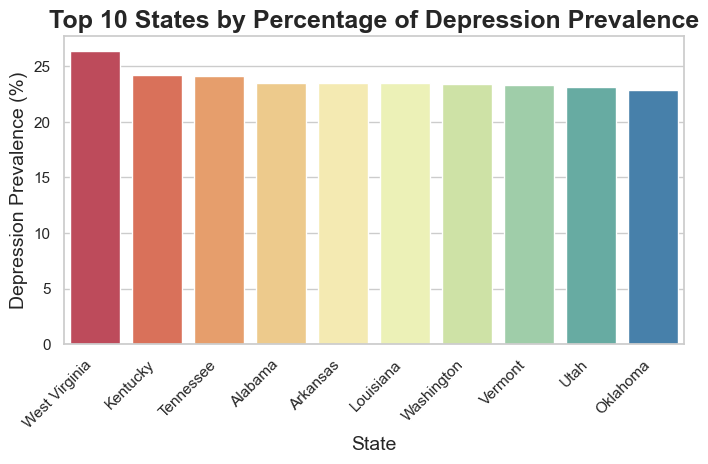

In [60]:
country_sorted = final_country_perc.sort_values(by='prevalence_percent', ascending=False)
data_chart = pd.DataFrame(country_sorted)
df_top_10 = data_chart.head(10)
#Setup Visualization Style ---
sns.set_theme(style="whitegrid")

#Create the Bar Chart using the Filtered Data ---
plt.figure(figsize=(8,4))

# Plot only the df_top_10 DataFrame
bar_plot = sns.barplot(
    x='state',
    y='prevalence_percent',
    data=df_top_10, # <-- Using the filtered DataFrame
    palette='Spectral'
)

#Enhance the Plot ---
plt.title('Top 10 States by Percentage of Depression Prevalence', fontsize=18, fontweight='bold')
plt.xlabel('State', fontsize=14)
plt.ylabel('Depression Prevalence (%)', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.show()

In [61]:
## Merge the table of depression percent per year with the main df table 
df_depressed=pd.merge(df,final_country_perc,on="state")

In [62]:
df_depressed

,incident_id,incident_date,incident_time,updated_date,state,city_or_county,address,business_location_name,latitude,longitude,killed,injured,victims_killed,victims_injured,suspects_killed,suspects_injured,suspects_arrested,incident_characteristics,sources,date_fixed,year,prevalence_percent
0,809048,"April 1, 2017",NaN,1491348530,Florida,Tampa,219 S Howard Ave,Palace Lounge,27.9431,-82.4831,1,4,1,4,0,0,1,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""http://wfla.com/2017/04/01/tampa-police-inv...",2017-04-01,2017,14.7
1,809499,"April 1, 2017",5:25 AM,1680156402,Oklahoma,Oklahoma City,1212 N Woodward Ave,NaN,35.4810,-97.5754,2,3,2,3,0,0,1,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""http://www.news9.com/story/35055747/okc-pol...",2017-04-01,2017,22.9
2,809815,"April 1, 2017",NaN,1492995601,California,Pittsburg,100 block of Madoline Street,NaN,38.0053,-121.8950,0,5,0,5,0,0,1,"Shot - Wounded/Injured, Mass Shooting (4+ vict...",http://www.nbcbayarea.com/news/local/Shooting-...,2017-04-01,2017,14.1
3,1082835,"April 1, 2018",2:15 AM,1522693801,Michigan,Saginaw,600 block of Yale St,NaN,43.4192,-83.9819,0,5,0,5,0,0,0,"Shot - Wounded/Injured, Mass Shooting (4+ vict...",http://www.mlive.com/news/saginaw/index.ssf/20...,2018-04-01,2018,19.5
4,1083011,"April 1, 2018",NaN,1646889853,Alabama,Mobile,3556 Halls Mill Rd,Grand Hall,30.6387,-88.1228,1,4,1,4,0,0,3,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""http://www.al.com/news/mobile/index.ssf/201...",2018-04-01,2018,23.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5463,2411007,"September 9, 2022",4:50 PM,1722738993,New York,Bronx,810 Astor Ave,Pelham Parkway Houses,40.8592,-73.8634,0,4,0,4,0,0,1,"Shot - Wounded/Injured, Mass Shooting (4+ vict...","c(""https://twitter.com/NYC_Alerts911/status/15...",2022-09-09,2022,16.8
5464,2411901,"September 9, 2022",11:50 PM,1689272621,Minnesota,Minneapolis,328 W Broadway Ave,4th Street Saloon,44.9994,-93.2848,1,3,1,3,0,0,0,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""https://www.fox9.com/news/2-pregnant-women-...",2022-09-09,2022,19.8
5465,2410446,"September 9, 2022",9:00 AM,1715920831,Maryland,Elk Mills,47 Hebron Ct,NaN,39.6611,-75.8365,5,0,4,0,1,0,0,"Shot - Dead (murder, accidental, or suicide), ...","c(""https://www.cbsnews.com/baltimore/news/five...",2022-09-09,2022,15.7
5466,2703975,"September 9, 2023",11:30 PM,1694472936,South Carolina,Rock Hill,800 block of Brunswick Dr,NaN,34.8921,-81.0411,0,4,0,4,0,0,2,"Shot - Wounded/Injured, Mass Shooting (4+ vict...",https://www.heraldonline.com/news/local/crime/...,2023-09-09,2023,21.4


In [63]:
incident_count = df_depressed.groupby("state").agg({"incident_id":"count","prevalence_percent":"mean"})
incident_count

,incident_id,prevalence_percent
state,,
Alabama,145,23.5
Alaska,6,15.9
Arizona,61,17.4
Arkansas,62,23.5
California,471,14.1
Colorado,87,18.5
Connecticut,35,17.7
Delaware,21,15.6
District of Columbia,90,19.8


In [64]:
cor_check=incident_count.sort_values(by="incident_id", ascending=False)
cor_check.rename(columns={"incident_id":"incident_count"}, inplace=True)

#Comparing the top 10 states with highest depression percentage $ top 10 states with highest gun incidents, 
#only Tennessee appears on both list, prompting a correlation relationship check.

/var/folders/wc/048rx86x7bqbzmjn7nr46j_80000gn/T/ipykernel_57911/1723849659.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




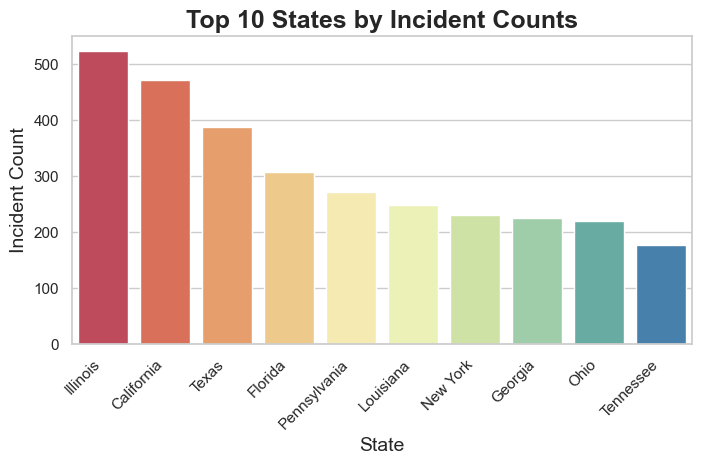

In [65]:
incident_sorted = cor_check.sort_values(by="incident_count", ascending=False)
data_chart2 = pd.DataFrame(incident_sorted)
df_top_10 = data_chart2.head(10)
#Setup Visualization Style ---
sns.set_theme(style="whitegrid")

#Create the Bar Chart using the Filtered Data ---
plt.figure(figsize=(8,4))

# Plot only the df_top_10 DataFrame
bar_plot = sns.barplot(
    x='state',
    y='incident_count',
    data=df_top_10, # <-- Using the filtered DataFrame
    palette='Spectral'
)

#Enhance the Plot ---
plt.title('Top 10 States by Incident Counts', fontsize=18, fontweight='bold')
plt.xlabel('State', fontsize=14)
plt.ylabel('Incident Count', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.show()

In [66]:
r_coeff, p_value = pearsonr(cor_check['incident_count'], cor_check['prevalence_percent'])
print("--- Analysis of Weak Correlation ---")
print(f"Pearson r: {r_coeff:.4f}")
print(f"P-value: {p_value:.4f}")

--- Analysis of Weak Correlation ---
Pearson r: -0.2423
P-value: 0.0867


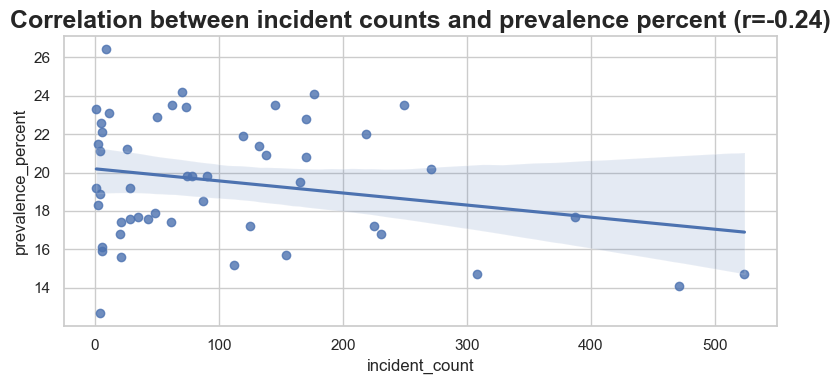

In [67]:
## Corellation plot for incident counts and depression percentage
plt.figure(figsize=(8, 4))
sns.regplot(x='incident_count', y='prevalence_percent', data=cor_check)
plt.title(f'Correlation between incident counts and prevalence percent (r={cor_check['incident_count'].corr(cor_check['prevalence_percent']):.2f})', fontsize=18, fontweight='bold')

plt.tight_layout()
plt.show()

# Hypothesis
H0: There is no linear relationship between incident counts and depression prevalence r=0 <p>
H1: There is a linear relationship between incident counts and depression prevalence r!=0 <p>
Since P-value>0.05, there is no statistical significance in the correlation.
We accept the alternative hypothesis.
This implies that the number of incidents increases as the depression prevalence in percentage reduces for all states.